# results visualization

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


with open('output_MRP/test_tables_train8_test2.pkl', 'rb') as file:
    test_list = pickle.load(file)

with open('output_MRP/train_tables_train8_test2.pkl', 'rb') as file:
    train_list = pickle.load(file)



In [24]:

mask = []
for i in range(len(test_list)):
    table = test_list[i]
    val = (table['portfolio_value'] >= 0).all()
    mask.append(val)

test_list_filtered = [test_list[i] for i in range(len(test_list)) if mask[i]]
len(test_list_filtered)


77

## Part I: statistics report

In [25]:
def trade_table_statistics(table):

    # calculate the daily return
    table['ret'] = table['cum_ret'] / table['cum_ret'].shift(1) - 1

    # 1. calcualte number of openings/closings achieved during the period
    prev_pos = table['position'].shift(1)
    prev_pos.iloc[0] = 0
    mask = (table['position'] == 0)
    num_closings = np.sum(np.abs(prev_pos[mask]))

    mask = (prev_pos == 0)
    num_openings = np.sum(np.abs(table['position'][mask]))


    # 2. cum return over the period
    final_cum_ret = table['cum_ret'].iloc[-1]

    # 3. start_date and end_date
    start_date = table.index[0]
    end_date = table.index[-1]

    # 4. max_drawdown
    cum_ret = table['cum_ret']

    def calculate_max_drawdown(value_series):
        curr_max = value_series.iloc[0]
        max_drawdown = 0

        for val in value_series:
            if val > curr_max:
                curr_max = val

            drawdown = val / curr_max - 1
            if drawdown < max_drawdown:
                max_drawdown = drawdown


        return max_drawdown

    max_drawdown = calculate_max_drawdown(cum_ret)

    # 5. nav percentile
    cum_ret = table['cum_ret']
    nav_min = np.min(cum_ret)
    nav_max = np.max(cum_ret)
    nav_median = np.median(cum_ret)
    nav_25 = np.percentile(cum_ret, 25)
    nav_75 = np.percentile(cum_ret, 75)

    # 6. sharpe ratio (daily basis)
    daily_ret = table['ret'].iloc[1:] # first ret is NaN
    sharpe_daily = np.mean(daily_ret) / np.std(daily_ret)

    # 7. geometric averate daily ret
    cum_ret = table['cum_ret'].iloc[-1]
    num_periods = len(table) - 1
    average_daily_ret = cum_ret ** (1/num_periods) - 1 

    # 8. average holding period
    def calculate_holding_periods(position_series):
        total_holding_days = 0
        total_num_opens = 0
        curr_open = False

        for position in position_series:
            if not curr_open:
                if position != 0:
                    curr_open = True
                    total_num_opens += 1
            else:
                total_holding_days += 1
                if position == 0:
                    curr_open = False
        average_holding_period = total_holding_days / total_num_opens

        return average_holding_period
    position_series = table['position']
    average_holding_period = calculate_holding_periods(position_series)

    stats = {
        'start_date': start_date,
        'end_date': end_date,

        'sharpe_daily': sharpe_daily,
        'cum_return': final_cum_ret,
        'max_drawdown': max_drawdown,
        'average_daily_ret': average_daily_ret,

        'nav_min': nav_min,
        'nav_25': nav_25,
        'nav_median': nav_median,
        'nav_75': nav_75,
        'nav_max': nav_max,

        'num_openings': num_openings,
        'num_closings': num_closings,
        'average_holding_period': average_holding_period,
    }
    
    return stats


def create_stats_summary(table_list):
    summary_df = pd.DataFrame()
    
    for table in table_list:

        stats = trade_table_statistics(table)
        stats_df = pd.DataFrame([stats])
        summary_df = pd.concat([summary_df, stats_df], ignore_index=True)
    
    return summary_df

# stats_df = create_stats_summary(test_list)
stats_df = create_stats_summary(test_list_filtered)
stats_df.head()


,start_date,end_date,sharpe_daily,cum_return,max_drawdown,average_daily_ret,nav_min,nav_25,nav_median,nav_75,nav_max,num_openings,num_closings,average_holding_period
0,1990-08-29,1990-10-26,-0.077916,0.854713,-0.206417,-0.003822,0.793583,0.838560,0.899075,0.924961,1.000000,1.0,0.0,41.000000
1,1990-10-26,1990-12-26,-0.080570,0.797881,-0.269578,-0.005492,0.742041,0.842329,0.898845,0.944256,1.015908,1.0,0.0,40.000000
2,1990-12-26,1991-02-25,0.030981,0.997367,-0.320248,-0.000064,0.933459,1.001481,1.102706,1.260440,1.373234,4.0,3.0,8.250000
3,1991-02-25,1991-04-24,0.388756,1.604982,-0.047920,0.011606,1.000000,1.131744,1.175978,1.423281,1.604982,8.0,8.0,3.000000
4,1991-04-24,1991-06-21,0.389338,1.686698,-0.074969,0.012832,1.000000,1.249474,1.341942,1.529899,1.686698,7.0,7.0,4.714286


In [26]:
stats_df.describe()

,start_date,end_date,sharpe_daily,cum_return,max_drawdown,average_daily_ret,nav_min,nav_25,nav_median,nav_75,nav_max,num_openings,num_closings,average_holding_period
count,77,77,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,1997-01-09 16:12:28.051948032,1997-03-10 00:18:42.077922048,0.103224,1.200517,-0.186517,0.002272,0.899513,1.017838,1.117555,1.247410,1.383682,3.961039,3.064935,14.704630
min,1990-08-29 00:00:00,1990-10-26 00:00:00,-0.494874,0.152140,-0.886413,-0.044887,0.151650,0.271557,0.295230,0.855327,1.000000,1.000000,0.000000,2.363636
25%,1993-09-28 00:00:00,1993-11-24 00:00:00,-0.038059,0.936187,-0.207813,-0.001607,0.888830,0.955189,0.990195,1.006779,1.067495,2.000000,1.000000,5.666667
50%,1996-12-24 00:00:00,1997-02-24 00:00:00,0.111940,1.142405,-0.129527,0.003252,0.973672,1.023469,1.083720,1.135774,1.225562,4.000000,3.000000,9.000000
75%,2000-01-27 00:00:00,2000-03-27 00:00:00,0.205275,1.320060,-0.066794,0.006796,1.000000,1.113934,1.171937,1.312742,1.452451,5.000000,4.000000,19.500000
max,2003-10-29 00:00:00,2003-12-29 00:00:00,0.511442,3.837442,-0.031159,0.033344,1.000000,1.513557,2.782061,3.214973,3.837442,11.000000,11.000000,41.000000
std,NaN,NaN,0.172394,0.555732,0.185997,0.010973,0.175062,0.197844,0.311924,0.424802,0.539676,2.330809,2.429737,12.911941


In [29]:
np.argmax(stats_df['cum_return'])

27

In [36]:
test_list_filtered[5]

,portfolio_value,residuals,threshold,trade_signal,unwind_signal,position,cum_ret,ret
date,,,,,,,,
1991-06-21,20.251160,-0.018547,0.460676,0,0,0.0,1.000000,NaN
1991-06-24,20.532713,0.263006,0.460676,0,1,0.0,1.000000,0.000000
1991-06-25,20.255546,-0.014161,0.460676,0,1,0.0,1.000000,0.000000
1991-06-26,20.366146,0.096439,0.460676,0,1,0.0,1.000000,0.000000
1991-06-27,19.928190,-0.341517,0.460676,0,1,0.0,1.000000,0.000000
1991-06-28,18.757510,-1.512197,0.460676,1,0,1.0,1.000000,0.000000
1991-07-01,20.418042,0.148335,0.460676,0,1,0.0,1.088526,0.088526
1991-07-02,19.875684,-0.394023,0.460676,0,1,0.0,1.088526,0.000000
1991-07-03,19.626348,-0.643359,0.460676,1,0,1.0,1.088526,0.000000


## Part II: trading snapshot

In [44]:
train_list[22]

,portfolio_value,residuals,threshold,trade_signal,unwind_signal,position,cum_ret
date,,,,,,,
1993-07-27,9.900399,-0.049208,0.492581,0,0,0.0,1.000000
1993-07-28,11.241634,1.292027,0.492581,-1,1,-1.0,1.000000
1993-07-29,11.370349,1.420742,0.492581,-1,0,-1.0,0.988550
1993-07-30,10.332747,0.383139,0.492581,0,0,-1.0,1.078760
1993-08-02,9.497801,-0.451806,0.492581,0,1,0.0,1.165930
...,...,...,...,...,...,...,...
1994-03-16,9.349917,-0.599690,0.492581,1,1,1.0,181.770602
1994-03-17,8.971956,-0.977651,0.492581,1,0,1.0,174.422716
1994-03-18,9.140241,-0.809366,0.492581,1,0,1.0,177.694324


In [9]:
test_list[59]

,portfolio_value,residuals,threshold,trade_signal,unwind_signal,position,cum_ret,ret
date,,,,,,,,
2000-03-27,-0.519310,-2.619542,0.676632,1,0,1.0,1.000000,NaN
2000-03-28,1.350681,-0.749551,0.676632,1,0,1.0,4.600915,3.600915
2000-03-29,-0.453095,-2.553327,0.676632,1,0,1.0,-1.543408,-1.335457
2000-03-30,1.989282,-0.110950,0.676632,0,0,1.0,-9.863039,5.390430
2000-03-31,-0.634299,-2.734531,0.676632,1,0,1.0,3.144913,-1.318858
2000-04-03,3.133503,1.033271,0.676632,-1,1,0.0,21.826018,5.940101
2000-04-04,2.603877,0.503645,0.676632,0,0,0.0,21.826018,0.000000
2000-04-05,3.042019,0.941787,0.676632,-1,0,-1.0,21.826018,0.000000
2000-04-06,3.532231,1.431999,0.676632,-1,0,-1.0,18.308823,-0.161147


In [18]:
count = 0
mean_list  = []
for i in range(len(test_list)):
    table = test_list[i]
    if (table['portfolio_value'] >= 0).all():
        count += 1
        mean_list.append(table['portfolio_value'].mean())

In [19]:
count

77

In [21]:
min(mean_list)

1.5336105721917186

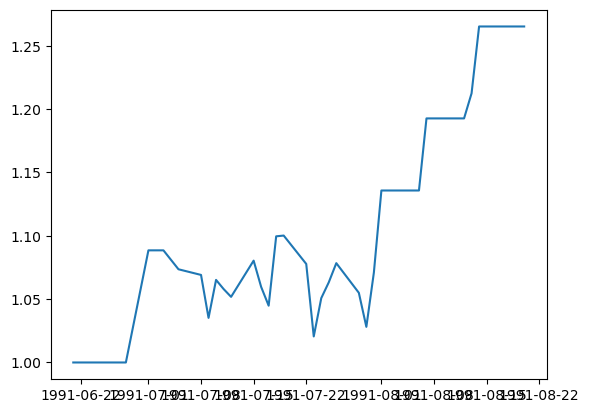

In [5]:
plt.plot(test_list[5]['cum_ret'])

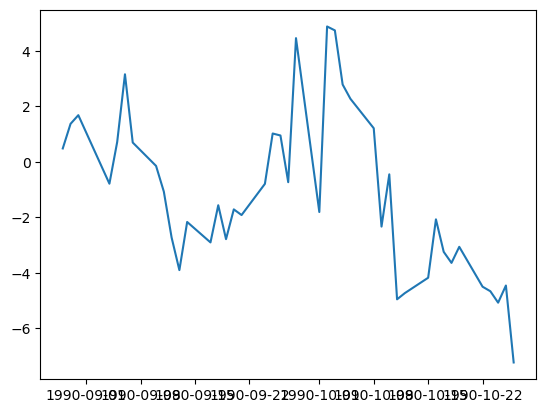

In [52]:
plt.plot(test_list[0]['residuals'])

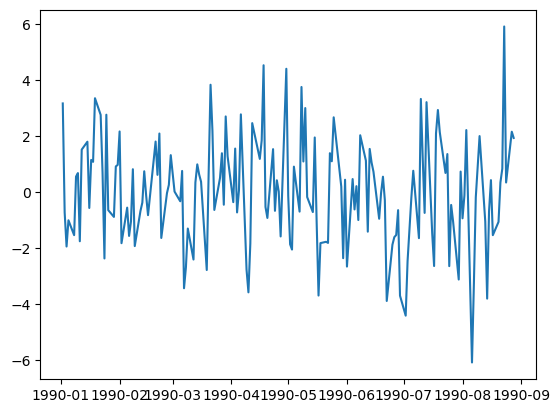

In [53]:
plt.plot(train_list[0]['residuals'])

In [70]:
train_list[1].tail(30)

,portfolio_value,residuals,threshold,trade_signal,unwind_signal,position,cum_ret
date,,,,,,,
1990-09-14,-1.168654,-0.229217,0.998051,0,0,1.0,-2.772798e+19
1990-09-17,-3.803932,-2.864495,0.998051,1,0,1.0,3.479772e+19
1990-09-18,0.931775,1.871212,0.998051,-1,1,0.0,7.811916e+19
1990-09-19,-3.224472,-2.285035,0.998051,1,1,1.0,7.811916e+19
1990-09-20,0.062914,1.002351,0.998051,-1,1,0.0,1.577625e+20
1990-09-21,0.522548,1.461985,0.998051,-1,0,-1.0,1.577625e+20
1990-09-24,0.221528,1.160965,0.998051,-1,0,-1.0,2.486436e+20
1990-09-25,-2.038949,-1.099512,0.998051,1,1,0.0,2.785810e+21
1990-09-26,-1.993913,-1.054476,0.998051,1,0,1.0,2.785810e+21


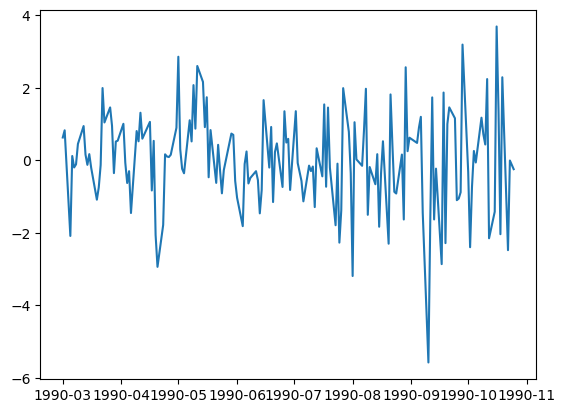

In [61]:
plt.plot(train_list[1]['residuals'])